In [1]:
import pandas as pd
import xlrd
import openpyxl
import numpy as np

IMPORT DATA

In [2]:
# index_col setta una colonna come index di pd.DataFrame
data: pd.DataFrame = pd.read_excel("C:/Users/andre/Desktop/Asset.xlsx", index_col="datetime")

CALC RETURNS

In [3]:
rf = 0.0001
# applica log a data e dopo fa la differenza prima con diff(); dropna() elimina i NaN dal DataFrame
# provare a stampare log_ret con e senza .dropna()
log_ret: pd.DataFrame = np.log(data).diff().dropna()
log_ret.head()

,AAPL,ABI,W5000,SP500,EUR_USD,USD_YEN
datetime,,,,,,
2009-01-05,0.041338,0.098272,-0.022958,-0.004679,0.001071,0.000738
2009-01-06,-0.016632,-0.017332,-0.024068,0.007787,-0.001357,0.001685
2009-01-07,-0.021845,-0.006007,0.003633,-0.030469,-0.011139,0.003467
2009-01-08,0.018399,0.039262,-0.035037,0.003391,0.007129,0.016641
2009-01-09,-0.023135,-0.010968,0.004174,-0.021533,0.015662,-0.016641


In [4]:
log_ret.describe().round(4)

,AAPL,ABI,W5000,SP500,EUR_USD,USD_YEN
count,2767.0000,2767.0000,2767.0000,2767.0000,2767.0000,2767.0000
mean,0.0011,0.0004,0.0005,0.0004,-0.0001,0.0000
std,0.0167,0.0153,0.0105,0.0103,0.0056,0.0058
min,-0.1319,-0.1196,-0.0733,-0.0690,-0.0265,-0.0375
25%,-0.0070,-0.0077,-0.0037,-0.0035,-0.0033,-0.0030
50%,0.0010,0.0003,0.0006,0.0007,0.0000,0.0000
75%,0.0102,0.0087,0.0055,0.0053,0.0030,0.0031
max,0.0850,0.0983,0.0677,0.0684,0.0302,0.0346


DEFINE INPUT FOR REGRESSION

In [5]:
Y: pd.DataFrame = log_ret.loc[:, ["AAPL"]] - rf # usare [] quando si selezionano le colonne per ottenere un pd.DataFrame 
X: pd.DataFrame = log_ret.loc[:, ["SP500", "EUR_USD", "USD_YEN"]]  # seleziona mkt factor e tasso cambio

X.loc[:, "SP500"] = X.loc[:, "SP500"] - rf  # sostituisce mkt factor con mkt factor - risk_free
# ALTERNATIVA: X.loc["SP500"] -= rf
X['constant'] = 1  # aggiunge una colonna di 1 IN ULTIMA POSIZIONE

X: pd.DataFrame = X.loc[:, ["constant", "SP500", "EUR_USD", "USD_YEN"]]  # ri-definisco X come X che segue un'ordinamento delle colonne specifico

In [6]:
Y.head()

,AAPL
datetime,
2009-01-05,0.041238
2009-01-06,-0.016732
2009-01-07,-0.021945
2009-01-08,0.018299
2009-01-09,-0.023235


In [7]:
X.head()

,constant,SP500,EUR_USD,USD_YEN
datetime,,,,
2009-01-05,1,-0.004779,0.001071,0.000738
2009-01-06,1,0.007687,-0.001357,0.001685
2009-01-07,1,-0.030569,-0.011139,0.003467
2009-01-08,1,0.003291,0.007129,0.016641
2009-01-09,1,-0.021633,0.015662,-0.016641


CALC REGRESSION'S COEFFICIENTS

In [8]:
coeffs: pd.DataFrame = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ Y
coeffs.index = X.columns  # oltre al matching tra (rows, columns) matriciale; deve matchare anche il nome delle righe con quello delle colonne
coeffs

,AAPL
constant,0.000680
SP500,0.994181
EUR_USD,0.029182
USD_YEN,0.055324


In [57]:
Y_hat: pd.DataFrame = X @ coeffs

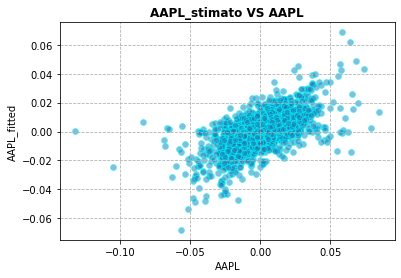

In [59]:
import matplotlib.pyplot as plt  # super estetica, utilizzare libreria seaborn
# to show figure inline (into notebook)
%matplotlib inline

# PLOT - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
plt.figure()
plt.scatter(x=Y, y=Y_hat, alpha=0.5, edgecolor='cyan')
plt.plot()
plt.xlabel("AAPL")
plt.ylabel("AAPL_fitted")
plt.grid(linestyle='dashed')
plt.title("AAPL_stimato VS AAPL", fontweight='bold')
plt.show()

In [64]:
# SUBPLOT - https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# to show figure in an external window
%matplotlib qt
fig, axs = plt.subplots(2, 1)

axs[0].plot(Y.index, Y.cumsum(), linewidth=1.2, color='cyan')
axs[0].plot(Y_hat.index, Y_hat.cumsum(), linewidth=1.2, color='red')
axs[0].set_title("Cumulative Returns", fontweight='bold')
axs[0].legend(['Real', 'Estimated'], fontsize='medium')
axs[0].grid(linestyle='dashed')

axs[1].plot(Y.index, Y, linewidth=0.5, color='cyan')
axs[1].plot(Y_hat.index, Y_hat, linewidth=0.5, color='red')
axs[1].set_title("Returns", fontweight='bold')
axs[1].legend(['Real', 'Estimated'], fontsize='medium')
axs[1].grid(linestyle='dashed')

In [65]:
TSS: np.array = ((Y-np.mean(Y)).transpose() @ (Y-np.mean(Y))).values   # domandare per metodo .to_numpy()
ESS: np.array = ((Y_hat-np.mean(Y)).transpose() @ (Y_hat-np.mean(Y))).values   # domandare per metodo .to_numpy()
res: pd.DataFrame = Y - Y_hat
SSE: np.array = (res.transpose() @ res).values   # domandare per metodo .to_numpy()
R_2 = ESS/TSS
T: int = X.shape[0]
K: int = X.shape[1]
R_2_adj = 1 - (((T-1)/(T-K))*(1-R_2))
sig_2 = SSE/(T-K)
varcov: np.array = np.linalg.inv(X.transpose() @ X) * sig_2
standard_errors = np.sqrt(np.diag(varcov))

In [66]:
coeffs["T-stat"] = coeffs["AAPL"].values / standard_errors   # domandare per metodo .to_numpy()
coeffs

,AAPL,T-stat
constant,0.000680,2.690075
SP500,0.994181,40.380846
EUR_USD,0.029182,0.621787
USD_YEN,0.055324,1.220805


In [68]:
from scipy.stats import t as t_student

t_stat_beta_mkt: float = coeffs.loc["SP500", "T-stat"] 
t_stat_beta_fx: float = coeffs.loc["EUR_USD", "T-stat"]

# test bilaterale     
# test size 5%
critical_value: float = np.abs(t_student.ppf(q=1 - 0.05/2, df=T-K))
    
print('Beta SP500 t-value: ', t_stat_beta_mkt)
print('Beta EUR/USD t-value: ', t_stat_beta_fx)

print('\nCritical Value t-student (a=0.05): ', critical_value)

if t_stat_beta_mkt > critical_value:
    print('\nReject the null-hypothesis. Il Beta di Mercato è statisticamente diverso da 0. Vi è una relazione lineare tra SP500 e AAPL')
else:
    print("\nNot reject the null-hypothesis. Il Beta di Mercato è statisticamente uguale a 0. Non vi è una relazione lineare tra SP500 e AAPL")

Beta SP500 t-value:  40.38084587127951
Beta EUR/USD t-value:  0.6217868977640706

Critical Value t-student (a=0.05):  1.9608229396972119

Not reject the null-hypothesis. Il Beta di Mercato è statisticamente diverso da 0. Vi è una relazione lineare tra SP500 e AAPL


In [69]:
# Stima del modello ridotto
X_restricted: pd.DataFrame = X.loc[:, ["constant"]]
coeffs_restricted: pd.DataFrame = np.linalg.inv(X_restricted.transpose() @ X_restricted) @ X_restricted.transpose() @ Y
coeffs_restricted.index = X_restricted.columns  # oltre al matching tra (rows, columns) matriciale; deve matchare anche il nome delle righe con quello delle colonne
coeffs_restricted

,AAPL
constant,0.001028


In [70]:
Y_hat_restricted: pd.DataFrame = X_restricted @ coeffs_restricted
res_restricted: pd.DataFrame = Y - Y_hat_restricted
SSE_restricted: np.array = (res_restricted.transpose() @ res_restricted).values   # domandare per metodo .to_numpy()

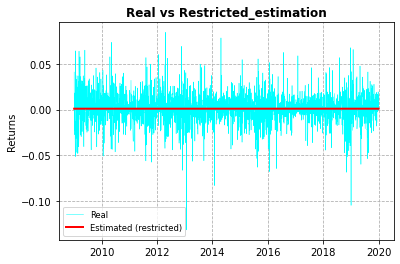

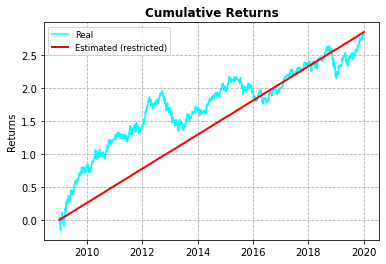

In this case, using Y_hat_restricted that has only the constant term, estimation is basically the mean (try to check if its value is equal to the mean in the above describing table).


In [82]:
%matplotlib inline

plt.figure()
plt.plot(Y.index, Y, linewidth=0.5, color='cyan')
plt.plot(Y_hat_restricted.index, Y_hat_restricted, linewidth=2, color='red')
plt.title('Real vs Restricted_estimation', fontweight='bold')
plt.ylabel('Returns')
plt.grid(linestyle='dashed')
plt.legend(['Real', "Estimated (restricted)"], fontsize='small')
plt.show()

%matplotlib inline

plt.figure()
plt.plot(Y.index, Y.cumsum(), color='cyan')
plt.plot(Y_hat_restricted.index, Y_hat_restricted.cumsum(), linewidth=2, color='red')
plt.title('Cumulative Returns', fontweight='bold')
plt.ylabel('Returns')
plt.grid(linestyle='dashed')
plt.legend(['Real', "Estimated (restricted)"], fontsize='small')
plt.show()

print("In this case, using Y_hat_restricted that has only the constant term, estimation is basically the mean (try to check if its value is equal to the mean in the above describing table).")

In [89]:
# F-STAT:
# Ipotesi nulla beta_mkt = beta_EUR_USD = beta_USD_YEN = 0

from scipy.stats import f as f_fisher

F = ((SSE_restricted - SSE)/(K-1))/(SSE/(T-K))
critical_value: float = f_fisher.ppf(0.90, K-1, T-K)
    
print("F-value: ",F[0][0])
print("Critical-value: ", critical_value)

# we reject the null
if F > critical_value:
    print("\nWe Reject the null")
else:
    print("\nWe Not Reject the null")
    

F-value:  543.5683509255821
Critical-value:  2.0857775749091774

We Reject the null


In [ ]:
# Potremmo lasciare come esercizio:
#
# 1. Rifare la regressione su ABI e W500 (sono in grado di farlo senza usare un for infinito ma usando le proprietà matriciali?)
# 2. Fare forecast per esercizio (in-sample / out-sample)
# 3. Calcolare Intervallo di Confidenza (IC). Provare a plottare cum-rets usando il Beta risultante da OLS e i beta che assumo valore agli estremi dell'IC. Stiamo visualizzando un intervallo di confidenza della regressione?